In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


Loaded 159606 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 nddf6x27


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-nddf6x27:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/1870 [00:00<19:35,  1.59it/s]

  0%|▍                                                                                                                                         | 6/1870 [00:00<03:01, 10.29it/s]

  1%|▊                                                                                                                                        | 11/1870 [00:00<01:41, 18.35it/s]

  1%|█▏                                                                                                                                       | 16/1870 [00:00<01:13, 25.35it/s]

  1%|█▌                                                                                                                                       | 21/1870 [00:01<00:59, 31.26it/s]

  1%|█▉                                                                                                                                       | 27/1870 [00:01<00:50, 36.83it/s]

  2%|██▎                                                                                                                                      | 32/1870 [00:01<00:45, 40.15it/s]

  2%|██▊                                                                                                                                      | 38/1870 [00:01<00:42, 43.19it/s]

  2%|███▏                                                                                                                                     | 43/1870 [00:01<00:40, 44.99it/s]

  3%|███▌                                                                                                                                     | 48/1870 [00:01<00:39, 46.32it/s]

  3%|███▉                                                                                                                                     | 53/1870 [00:01<00:38, 47.35it/s]

  3%|████▏                                                                                                                                    | 58/1870 [00:01<00:37, 48.10it/s]

  3%|████▌                                                                                                                                    | 63/1870 [00:01<00:37, 48.62it/s]

  4%|████▉                                                                                                                                    | 68/1870 [00:01<00:36, 49.01it/s]

  4%|█████▎                                                                                                                                   | 73/1870 [00:02<00:36, 49.26it/s]

  4%|█████▋                                                                                                                                   | 78/1870 [00:02<00:36, 49.43it/s]

  4%|██████                                                                                                                                   | 83/1870 [00:02<00:36, 49.55it/s]

  5%|██████▍                                                                                                                                  | 88/1870 [00:02<00:35, 49.59it/s]

  5%|██████▊                                                                                                                                  | 93/1870 [00:02<00:35, 49.70it/s]

  5%|███████▏                                                                                                                                 | 98/1870 [00:02<00:35, 49.73it/s]

  6%|███████▍                                                                                                                                | 103/1870 [00:02<00:35, 49.80it/s]

  6%|███████▊                                                                                                                                | 108/1870 [00:02<00:35, 49.84it/s]

  6%|████████▏                                                                                                                               | 113/1870 [00:02<00:35, 49.88it/s]

  6%|████████▋                                                                                                                               | 119/1870 [00:03<00:35, 49.96it/s]

  7%|█████████                                                                                                                               | 124/1870 [00:03<00:34, 49.92it/s]

  7%|█████████▍                                                                                                                              | 129/1870 [00:03<00:34, 49.92it/s]

  7%|█████████▋                                                                                                                              | 134/1870 [00:03<00:34, 49.80it/s]

  7%|██████████▏                                                                                                                             | 140/1870 [00:03<00:34, 49.91it/s]

  8%|██████████▌                                                                                                                             | 145/1870 [00:03<00:34, 49.91it/s]

  8%|██████████▉                                                                                                                             | 151/1870 [00:03<00:34, 49.96it/s]

  8%|███████████▎                                                                                                                            | 156/1870 [00:03<00:34, 49.93it/s]

  9%|███████████▊                                                                                                                            | 162/1870 [00:03<00:34, 49.92it/s]

  9%|████████████▏                                                                                                                           | 167/1870 [00:03<00:34, 49.94it/s]

  9%|████████████▌                                                                                                                           | 172/1870 [00:04<00:34, 49.94it/s]

  9%|████████████▊                                                                                                                           | 177/1870 [00:04<00:33, 49.87it/s]

 10%|█████████████▏                                                                                                                          | 182/1870 [00:04<00:33, 49.88it/s]

 10%|█████████████▋                                                                                                                          | 188/1870 [00:04<00:33, 49.96it/s]

 10%|██████████████                                                                                                                          | 193/1870 [00:04<00:33, 49.92it/s]

 11%|██████████████▍                                                                                                                         | 198/1870 [00:04<00:33, 49.88it/s]

 11%|██████████████▊                                                                                                                         | 203/1870 [00:04<00:33, 49.86it/s]

 11%|███████████████▏                                                                                                                        | 208/1870 [00:04<00:33, 49.89it/s]

 11%|███████████████▍                                                                                                                        | 213/1870 [00:04<00:33, 49.92it/s]

 12%|███████████████▊                                                                                                                        | 218/1870 [00:04<00:33, 49.93it/s]

 12%|████████████████▏                                                                                                                       | 223/1870 [00:05<00:32, 49.92it/s]

 12%|████████████████▋                                                                                                                       | 229/1870 [00:05<00:32, 50.01it/s]

 13%|█████████████████                                                                                                                       | 235/1870 [00:05<00:32, 50.03it/s]

 13%|█████████████████▌                                                                                                                      | 241/1870 [00:05<00:32, 49.92it/s]

 13%|█████████████████▉                                                                                                                      | 246/1870 [00:05<00:32, 49.92it/s]

 13%|██████████████████▎                                                                                                                     | 251/1870 [00:05<00:32, 49.79it/s]

 14%|██████████████████▋                                                                                                                     | 257/1870 [00:05<00:32, 49.90it/s]

 14%|███████████████████                                                                                                                     | 262/1870 [00:05<00:32, 49.86it/s]

 14%|███████████████████▍                                                                                                                    | 267/1870 [00:05<00:32, 49.88it/s]

 15%|███████████████████▊                                                                                                                    | 272/1870 [00:06<00:32, 49.79it/s]

 15%|████████████████████▏                                                                                                                   | 277/1870 [00:06<00:31, 49.83it/s]

 15%|████████████████████▌                                                                                                                   | 283/1870 [00:06<00:31, 49.95it/s]

 15%|█████████████████████                                                                                                                   | 289/1870 [00:06<00:31, 50.00it/s]

 16%|█████████████████████▍                                                                                                                  | 295/1870 [00:06<00:31, 49.93it/s]

 16%|█████████████████████▊                                                                                                                  | 300/1870 [00:06<00:31, 49.92it/s]

 16%|██████████████████████▎                                                                                                                 | 306/1870 [00:06<00:31, 49.99it/s]

 17%|██████████████████████▋                                                                                                                 | 312/1870 [00:06<00:31, 50.05it/s]

 17%|███████████████████████▏                                                                                                                | 318/1870 [00:06<00:31, 49.92it/s]

 17%|███████████████████████▌                                                                                                                | 324/1870 [00:07<00:30, 50.08it/s]

 18%|████████████████████████                                                                                                                | 330/1870 [00:07<00:30, 50.09it/s]

 18%|████████████████████████▍                                                                                                               | 336/1870 [00:07<00:30, 50.08it/s]

 18%|████████████████████████▊                                                                                                               | 342/1870 [00:07<00:30, 50.02it/s]

 19%|█████████████████████████▎                                                                                                              | 348/1870 [00:07<00:30, 50.06it/s]

 19%|█████████████████████████▋                                                                                                              | 354/1870 [00:07<00:30, 50.06it/s]

 19%|██████████████████████████▏                                                                                                             | 360/1870 [00:07<00:30, 50.07it/s]

 20%|██████████████████████████▌                                                                                                             | 366/1870 [00:07<00:30, 50.05it/s]

 20%|███████████████████████████                                                                                                             | 372/1870 [00:08<00:29, 50.02it/s]

 20%|███████████████████████████▍                                                                                                            | 378/1870 [00:08<00:29, 50.06it/s]

 21%|███████████████████████████▉                                                                                                            | 384/1870 [00:08<00:29, 50.02it/s]

 21%|████████████████████████████▎                                                                                                           | 390/1870 [00:08<00:29, 50.05it/s]

 21%|████████████████████████████▊                                                                                                           | 396/1870 [00:08<00:29, 50.07it/s]

 21%|█████████████████████████████▏                                                                                                          | 402/1870 [00:08<00:29, 49.92it/s]

 22%|█████████████████████████████▋                                                                                                          | 408/1870 [00:08<00:29, 50.05it/s]

 22%|██████████████████████████████                                                                                                          | 414/1870 [00:08<00:29, 50.03it/s]

 22%|██████████████████████████████▌                                                                                                         | 420/1870 [00:09<00:29, 49.96it/s]

 23%|██████████████████████████████▉                                                                                                         | 425/1870 [00:09<00:28, 49.97it/s]

 23%|███████████████████████████████▎                                                                                                        | 430/1870 [00:09<00:28, 49.97it/s]

 23%|███████████████████████████████▋                                                                                                        | 436/1870 [00:09<00:28, 50.02it/s]

 24%|████████████████████████████████▏                                                                                                       | 442/1870 [00:09<00:28, 50.01it/s]

 24%|████████████████████████████████▌                                                                                                       | 448/1870 [00:09<00:28, 49.95it/s]

 24%|████████████████████████████████▉                                                                                                       | 453/1870 [00:09<00:28, 49.95it/s]

 25%|█████████████████████████████████▍                                                                                                      | 459/1870 [00:09<00:28, 50.13it/s]

 25%|█████████████████████████████████▊                                                                                                      | 465/1870 [00:09<00:28, 49.99it/s]

 25%|██████████████████████████████████▏                                                                                                     | 470/1870 [00:10<00:28, 49.80it/s]

 25%|██████████████████████████████████▌                                                                                                     | 475/1870 [00:10<00:27, 49.85it/s]

 26%|██████████████████████████████████▉                                                                                                     | 481/1870 [00:10<00:27, 49.95it/s]

 26%|███████████████████████████████████▎                                                                                                    | 486/1870 [00:10<00:27, 49.87it/s]

 26%|███████████████████████████████████▋                                                                                                    | 491/1870 [00:10<00:27, 49.88it/s]

 27%|████████████████████████████████████▏                                                                                                   | 497/1870 [00:10<00:27, 49.97it/s]

 27%|████████████████████████████████████▌                                                                                                   | 503/1870 [00:10<00:27, 49.96it/s]

 27%|████████████████████████████████████▉                                                                                                   | 508/1870 [00:10<00:27, 49.91it/s]

 27%|█████████████████████████████████████▍                                                                                                  | 514/1870 [00:10<00:27, 50.05it/s]

 28%|█████████████████████████████████████▊                                                                                                  | 520/1870 [00:11<00:26, 50.05it/s]

 28%|██████████████████████████████████████▎                                                                                                 | 526/1870 [00:11<00:26, 49.94it/s]

 28%|██████████████████████████████████████▌                                                                                                 | 531/1870 [00:11<00:26, 49.92it/s]

 29%|██████████████████████████████████████▉                                                                                                 | 536/1870 [00:11<00:26, 49.93it/s]

 29%|███████████████████████████████████████▎                                                                                                | 541/1870 [00:11<00:26, 49.94it/s]

 29%|███████████████████████████████████████▋                                                                                                | 546/1870 [00:11<00:26, 49.88it/s]

 29%|████████████████████████████████████████                                                                                                | 551/1870 [00:11<00:26, 49.86it/s]

 30%|████████████████████████████████████████▌                                                                                               | 557/1870 [00:11<00:26, 49.96it/s]

 30%|████████████████████████████████████████▉                                                                                               | 563/1870 [00:11<00:26, 49.95it/s]

 30%|█████████████████████████████████████████▎                                                                                              | 568/1870 [00:11<00:26, 49.96it/s]

 31%|█████████████████████████████████████████▋                                                                                              | 573/1870 [00:12<00:25, 49.93it/s]

 31%|██████████████████████████████████████████                                                                                              | 579/1870 [00:12<00:25, 50.02it/s]

 31%|██████████████████████████████████████████▌                                                                                             | 585/1870 [00:12<00:25, 50.17it/s]

 32%|██████████████████████████████████████████▉                                                                                             | 591/1870 [00:12<00:25, 50.07it/s]

 32%|███████████████████████████████████████████▍                                                                                            | 597/1870 [00:12<00:25, 50.08it/s]

 32%|███████████████████████████████████████████▊                                                                                            | 603/1870 [00:12<00:25, 50.07it/s]

 33%|████████████████████████████████████████████▎                                                                                           | 609/1870 [00:12<00:25, 50.02it/s]

 33%|████████████████████████████████████████████▋                                                                                           | 615/1870 [00:12<00:25, 50.03it/s]

 33%|█████████████████████████████████████████████▏                                                                                          | 621/1870 [00:13<00:24, 50.05it/s]

 34%|█████████████████████████████████████████████▌                                                                                          | 627/1870 [00:13<00:24, 50.00it/s]

 34%|██████████████████████████████████████████████                                                                                          | 633/1870 [00:13<00:24, 50.02it/s]

 34%|██████████████████████████████████████████████▍                                                                                         | 639/1870 [00:13<00:24, 50.05it/s]

 34%|██████████████████████████████████████████████▉                                                                                         | 645/1870 [00:13<00:24, 50.05it/s]

 35%|███████████████████████████████████████████████▎                                                                                        | 651/1870 [00:13<00:24, 49.98it/s]

 35%|███████████████████████████████████████████████▋                                                                                        | 656/1870 [00:13<00:24, 49.98it/s]

 35%|████████████████████████████████████████████████                                                                                        | 661/1870 [00:13<00:24, 49.97it/s]

 36%|████████████████████████████████████████████████▍                                                                                       | 666/1870 [00:13<00:24, 49.97it/s]

 36%|████████████████████████████████████████████████▊                                                                                       | 672/1870 [00:14<00:23, 50.01it/s]

 36%|█████████████████████████████████████████████████▎                                                                                      | 678/1870 [00:14<00:23, 49.95it/s]

 37%|█████████████████████████████████████████████████▋                                                                                      | 683/1870 [00:14<00:23, 49.94it/s]

 37%|██████████████████████████████████████████████████                                                                                      | 688/1870 [00:14<00:23, 49.91it/s]

 37%|██████████████████████████████████████████████████▍                                                                                     | 693/1870 [00:14<00:23, 49.92it/s]

 37%|██████████████████████████████████████████████████▊                                                                                     | 699/1870 [00:14<00:23, 49.99it/s]

 38%|███████████████████████████████████████████████████▏                                                                                    | 704/1870 [00:14<00:23, 48.65it/s]

 38%|███████████████████████████████████████████████████▌                                                                                    | 709/1870 [00:14<00:23, 48.99it/s]

 38%|███████████████████████████████████████████████████▉                                                                                    | 714/1870 [00:14<00:23, 49.18it/s]

 38%|████████████████████████████████████████████████████▎                                                                                   | 719/1870 [00:15<00:23, 49.40it/s]

 39%|████████████████████████████████████████████████████▋                                                                                   | 725/1870 [00:15<00:23, 49.63it/s]

 39%|█████████████████████████████████████████████████████                                                                                   | 730/1870 [00:15<00:22, 49.69it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                  | 736/1870 [00:15<00:22, 49.67it/s]

 40%|█████████████████████████████████████████████████████▉                                                                                  | 741/1870 [00:15<00:22, 49.68it/s]

 40%|██████████████████████████████████████████████████████▎                                                                                 | 746/1870 [00:15<00:22, 49.77it/s]

 40%|██████████████████████████████████████████████████████▌                                                                                 | 751/1870 [00:15<00:22, 49.81it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                 | 756/1870 [00:15<00:22, 49.86it/s]

 41%|███████████████████████████████████████████████████████▍                                                                                | 762/1870 [00:15<00:22, 49.94it/s]

 41%|███████████████████████████████████████████████████████▊                                                                                | 768/1870 [00:16<00:22, 50.00it/s]

 41%|████████████████████████████████████████████████████████▏                                                                               | 773/1870 [00:16<00:22, 49.77it/s]

 42%|████████████████████████████████████████████████████████▌                                                                               | 778/1870 [00:16<00:21, 49.80it/s]

 42%|████████████████████████████████████████████████████████▉                                                                               | 783/1870 [00:16<00:21, 49.84it/s]

 42%|█████████████████████████████████████████████████████████▎                                                                              | 788/1870 [00:16<00:21, 49.88it/s]

 42%|█████████████████████████████████████████████████████████▋                                                                              | 794/1870 [00:16<00:21, 49.95it/s]

 43%|██████████████████████████████████████████████████████████▏                                                                             | 800/1870 [00:16<00:21, 50.03it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                             | 806/1870 [00:16<00:21, 49.88it/s]

 43%|██████████████████████████████████████████████████████████▉                                                                             | 811/1870 [00:16<00:21, 49.91it/s]

 44%|███████████████████████████████████████████████████████████▍                                                                            | 817/1870 [00:16<00:21, 49.99it/s]

 44%|███████████████████████████████████████████████████████████▊                                                                            | 823/1870 [00:17<00:20, 50.06it/s]

 44%|████████████████████████████████████████████████████████████▎                                                                           | 829/1870 [00:17<00:20, 50.02it/s]

 45%|████████████████████████████████████████████████████████████▋                                                                           | 835/1870 [00:17<00:20, 50.04it/s]

 45%|█████████████████████████████████████████████████████████████▏                                                                          | 841/1870 [00:17<00:20, 50.07it/s]

 45%|█████████████████████████████████████████████████████████████▌                                                                          | 847/1870 [00:17<00:20, 50.00it/s]

 46%|██████████████████████████████████████████████████████████████                                                                          | 853/1870 [00:17<00:20, 49.98it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                         | 858/1870 [00:17<00:20, 49.95it/s]

 46%|██████████████████████████████████████████████████████████████▊                                                                         | 863/1870 [00:17<00:20, 49.93it/s]

 46%|███████████████████████████████████████████████████████████████▏                                                                        | 868/1870 [00:18<00:20, 49.88it/s]

 47%|███████████████████████████████████████████████████████████████▌                                                                        | 874/1870 [00:18<00:19, 49.95it/s]

 47%|███████████████████████████████████████████████████████████████▉                                                                        | 879/1870 [00:18<00:19, 49.96it/s]

 47%|████████████████████████████████████████████████████████████████▎                                                                       | 884/1870 [00:18<00:19, 49.81it/s]

 48%|████████████████████████████████████████████████████████████████▋                                                                       | 889/1870 [00:18<00:19, 49.70it/s]

 48%|█████████████████████████████████████████████████████████████████                                                                       | 894/1870 [00:18<00:19, 49.70it/s]

 48%|█████████████████████████████████████████████████████████████████▍                                                                      | 899/1870 [00:18<00:19, 49.75it/s]

 48%|█████████████████████████████████████████████████████████████████▋                                                                      | 904/1870 [00:18<00:19, 49.80it/s]

 49%|██████████████████████████████████████████████████████████████████▏                                                                     | 910/1870 [00:18<00:19, 49.92it/s]

 49%|██████████████████████████████████████████████████████████████████▌                                                                     | 916/1870 [00:18<00:19, 49.92it/s]

 49%|██████████████████████████████████████████████████████████████████▉                                                                     | 921/1870 [00:19<00:19, 49.76it/s]

 50%|███████████████████████████████████████████████████████████████████▍                                                                    | 927/1870 [00:19<00:18, 50.08it/s]

 50%|███████████████████████████████████████████████████████████████████▊                                                                    | 933/1870 [00:19<00:18, 50.06it/s]

 50%|████████████████████████████████████████████████████████████████████▎                                                                   | 939/1870 [00:19<00:18, 49.86it/s]

 50%|████████████████████████████████████████████████████████████████████▋                                                                   | 944/1870 [00:19<00:18, 49.73it/s]

 51%|█████████████████████████████████████████████████████████████████████                                                                   | 949/1870 [00:19<00:18, 49.71it/s]

 51%|█████████████████████████████████████████████████████████████████████▍                                                                  | 954/1870 [00:19<00:18, 49.75it/s]

 51%|█████████████████████████████████████████████████████████████████████▋                                                                  | 959/1870 [00:19<00:18, 49.80it/s]

 52%|██████████████████████████████████████████████████████████████████████▏                                                                 | 965/1870 [00:19<00:18, 49.90it/s]

 52%|██████████████████████████████████████████████████████████████████████▌                                                                 | 971/1870 [00:20<00:17, 49.97it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                 | 976/1870 [00:20<00:17, 49.82it/s]

 52%|███████████████████████████████████████████████████████████████████████▎                                                                | 981/1870 [00:20<00:17, 49.73it/s]

 53%|███████████████████████████████████████████████████████████████████████▋                                                                | 986/1870 [00:20<00:17, 49.79it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                               | 992/1870 [00:20<00:17, 49.91it/s]

 53%|████████████████████████████████████████████████████████████████████████▌                                                               | 997/1870 [00:20<00:17, 49.91it/s]

 54%|████████████████████████████████████████████████████████████████████████▎                                                              | 1002/1870 [00:20<00:17, 49.93it/s]

 54%|████████████████████████████████████████████████████████████████████████▊                                                              | 1008/1870 [00:20<00:17, 49.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████▏                                                             | 1013/1870 [00:20<00:17, 49.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████▍                                                             | 1018/1870 [00:21<00:17, 49.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████▊                                                             | 1023/1870 [00:21<00:16, 49.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 1028/1870 [00:21<00:16, 49.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████▌                                                            | 1033/1870 [00:21<00:16, 49.91it/s]

 56%|██████████████████████████████████████████████████████████████████████████▉                                                            | 1038/1870 [00:21<00:16, 49.75it/s]

 56%|███████████████████████████████████████████████████████████████████████████▎                                                           | 1044/1870 [00:21<00:16, 50.19it/s]

 56%|███████████████████████████████████████████████████████████████████████████▊                                                           | 1050/1870 [00:21<00:16, 49.80it/s]

 56%|████████████████████████████████████████████████████████████████████████████▏                                                          | 1055/1870 [00:21<00:16, 49.76it/s]

 57%|████████████████████████████████████████████████████████████████████████████▌                                                          | 1060/1870 [00:21<00:16, 49.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████▉                                                          | 1065/1870 [00:21<00:16, 49.76it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▏                                                         | 1070/1870 [00:22<00:16, 49.71it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                         | 1075/1870 [00:22<00:15, 49.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████████▉                                                         | 1080/1870 [00:22<00:15, 49.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▍                                                        | 1086/1870 [00:22<00:15, 49.92it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                        | 1092/1870 [00:22<00:15, 49.93it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▏                                                       | 1097/1870 [00:22<00:15, 49.93it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▌                                                       | 1102/1870 [00:22<00:15, 49.81it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▉                                                       | 1107/1870 [00:22<00:15, 49.75it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▎                                                      | 1112/1870 [00:22<00:15, 49.71it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▋                                                      | 1117/1870 [00:23<00:15, 49.73it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 1123/1870 [00:23<00:14, 49.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▍                                                     | 1128/1870 [00:23<00:14, 49.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▊                                                     | 1134/1870 [00:23<00:14, 49.91it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                    | 1139/1870 [00:23<00:14, 49.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▌                                                    | 1144/1870 [00:23<00:14, 49.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████                                                    | 1150/1870 [00:23<00:14, 49.95it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                   | 1155/1870 [00:23<00:14, 49.96it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▊                                                   | 1161/1870 [00:23<00:14, 49.93it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1166/1870 [00:23<00:14, 49.95it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1171/1870 [00:24<00:14, 49.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1176/1870 [00:24<00:13, 49.74it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1181/1870 [00:24<00:13, 49.69it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1186/1870 [00:24<00:13, 49.68it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1191/1870 [00:24<00:13, 49.58it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▎                                                | 1196/1870 [00:24<00:13, 49.57it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▋                                                | 1201/1870 [00:24<00:13, 49.62it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████                                                | 1206/1870 [00:24<00:13, 49.67it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▍                                               | 1211/1870 [00:24<00:13, 49.67it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 1216/1870 [00:24<00:13, 49.74it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1222/1870 [00:25<00:12, 49.85it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1227/1870 [00:25<00:12, 49.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1232/1870 [00:25<00:12, 49.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1237/1870 [00:25<00:12, 49.91it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1242/1870 [00:25<00:12, 49.93it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████                                             | 1247/1870 [00:25<00:12, 49.94it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1252/1870 [00:25<00:12, 49.94it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1257/1870 [00:25<00:12, 49.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████                                            | 1262/1870 [00:25<00:12, 49.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1267/1870 [00:26<00:12, 49.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1272/1870 [00:26<00:11, 49.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1277/1870 [00:26<00:11, 49.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1282/1870 [00:26<00:11, 49.91it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1287/1870 [00:26<00:11, 49.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1292/1870 [00:26<00:11, 49.90it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1297/1870 [00:26<00:11, 49.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1302/1870 [00:26<00:11, 49.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1307/1870 [00:26<00:11, 49.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1312/1870 [00:26<00:11, 49.75it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████                                        | 1317/1870 [00:27<00:11, 49.63it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1323/1870 [00:27<00:10, 49.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1329/1870 [00:27<00:10, 49.95it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1334/1870 [00:27<00:10, 49.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1340/1870 [00:27<00:10, 49.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1346/1870 [00:27<00:10, 49.92it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1351/1870 [00:27<00:10, 49.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1356/1870 [00:27<00:10, 49.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1361/1870 [00:27<00:10, 49.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1366/1870 [00:28<00:10, 49.72it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1371/1870 [00:28<00:10, 49.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1376/1870 [00:28<00:09, 49.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1382/1870 [00:28<00:09, 49.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1387/1870 [00:28<00:09, 49.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1392/1870 [00:28<00:09, 49.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1397/1870 [00:28<00:09, 49.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1403/1870 [00:28<00:09, 49.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1408/1870 [00:28<00:09, 49.93it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1413/1870 [00:28<00:09, 49.93it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1419/1870 [00:29<00:09, 49.94it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1424/1870 [00:29<00:08, 49.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1429/1870 [00:29<00:08, 49.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1434/1870 [00:29<00:08, 49.93it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1439/1870 [00:29<00:08, 49.92it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1444/1870 [00:29<00:08, 49.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1450/1870 [00:29<00:08, 49.99it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1455/1870 [00:29<00:08, 49.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1460/1870 [00:29<00:08, 49.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1465/1870 [00:29<00:08, 49.80it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1470/1870 [00:30<00:08, 49.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1475/1870 [00:30<00:07, 49.66it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1480/1870 [00:30<00:07, 49.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1486/1870 [00:30<00:07, 49.92it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1491/1870 [00:30<00:07, 49.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1496/1870 [00:30<00:07, 49.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1501/1870 [00:30<00:07, 49.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1506/1870 [00:30<00:07, 49.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1511/1870 [00:30<00:07, 49.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1516/1870 [00:31<00:07, 49.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1521/1870 [00:31<00:07, 49.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1527/1870 [00:31<00:06, 49.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1533/1870 [00:31<00:06, 49.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1538/1870 [00:31<00:06, 49.90it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1543/1870 [00:31<00:06, 49.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1548/1870 [00:31<00:06, 49.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1553/1870 [00:31<00:06, 49.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1558/1870 [00:31<00:06, 49.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1563/1870 [00:31<00:06, 49.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1568/1870 [00:32<00:06, 49.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1574/1870 [00:32<00:05, 49.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1579/1870 [00:32<00:05, 49.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1584/1870 [00:32<00:05, 49.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1589/1870 [00:32<00:05, 49.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1594/1870 [00:32<00:05, 49.59it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1599/1870 [00:32<00:05, 49.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1604/1870 [00:32<00:05, 49.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1610/1870 [00:32<00:05, 49.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1615/1870 [00:33<00:05, 49.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1620/1870 [00:33<00:05, 49.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1625/1870 [00:33<00:04, 49.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1631/1870 [00:33<00:04, 49.92it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1636/1870 [00:33<00:04, 49.92it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1641/1870 [00:33<00:04, 49.92it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1647/1870 [00:33<00:04, 49.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1652/1870 [00:33<00:04, 49.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1657/1870 [00:33<00:04, 49.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1662/1870 [00:33<00:04, 49.76it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1667/1870 [00:34<00:04, 49.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1673/1870 [00:34<00:03, 49.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1678/1870 [00:34<00:03, 49.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1683/1870 [00:34<00:03, 49.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1688/1870 [00:34<00:03, 49.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1693/1870 [00:34<00:03, 49.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1698/1870 [00:34<00:03, 49.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1703/1870 [00:34<00:03, 49.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1709/1870 [00:34<00:03, 49.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1714/1870 [00:34<00:03, 49.77it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1719/1870 [00:35<00:03, 49.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1724/1870 [00:35<00:02, 49.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1729/1870 [00:35<00:02, 49.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1734/1870 [00:35<00:02, 49.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1739/1870 [00:35<00:02, 49.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1744/1870 [00:35<00:02, 49.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1749/1870 [00:35<00:02, 49.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1754/1870 [00:35<00:02, 49.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1759/1870 [00:35<00:02, 49.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1764/1870 [00:36<00:02, 49.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1769/1870 [00:36<00:02, 49.69it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1774/1870 [00:36<00:01, 49.70it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1779/1870 [00:36<00:01, 49.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1784/1870 [00:36<00:01, 49.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1789/1870 [00:36<00:01, 49.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1794/1870 [00:36<00:01, 49.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1799/1870 [00:36<00:01, 49.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1804/1870 [00:36<00:01, 49.49it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1809/1870 [00:36<00:01, 49.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1814/1870 [00:37<00:01, 49.61it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1819/1870 [00:37<00:01, 49.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1824/1870 [00:37<00:00, 49.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1829/1870 [00:37<00:00, 49.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1834/1870 [00:37<00:00, 49.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1839/1870 [00:37<00:00, 49.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1844/1870 [00:37<00:00, 49.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1849/1870 [00:37<00:00, 49.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1855/1870 [00:37<00:00, 49.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1860/1870 [00:37<00:00, 49.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1865/1870 [00:38<00:00, 48.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:38<00:00, 45.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:38<00:00, 48.96it/s]

train - OK


  0%|                                                                                                                                                   | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                          | 1/468 [00:00<01:56,  4.01it/s]

  1%|█▊                                                                                                                                         | 6/468 [00:00<00:22, 20.35it/s]

  2%|███▏                                                                                                                                      | 11/468 [00:00<00:15, 30.18it/s]

  3%|████▋                                                                                                                                     | 16/468 [00:00<00:12, 36.48it/s]

  4%|██████▏                                                                                                                                   | 21/468 [00:00<00:10, 40.71it/s]

  6%|███████▉                                                                                                                                  | 27/468 [00:00<00:10, 43.98it/s]

  7%|█████████▍                                                                                                                                | 32/468 [00:00<00:09, 45.71it/s]

  8%|██████████▉                                                                                                                               | 37/468 [00:00<00:09, 46.86it/s]

  9%|████████████▍                                                                                                                             | 42/468 [00:01<00:08, 47.78it/s]

 10%|██████████████▏                                                                                                                           | 48/468 [00:01<00:08, 48.58it/s]

 12%|███████████████▉                                                                                                                          | 54/468 [00:01<00:08, 49.09it/s]

 13%|█████████████████▍                                                                                                                        | 59/468 [00:01<00:08, 49.33it/s]

 14%|██████████████████▊                                                                                                                       | 64/468 [00:01<00:08, 49.46it/s]

 15%|████████████████████▎                                                                                                                     | 69/468 [00:01<00:08, 49.53it/s]

 16%|█████████████████████▊                                                                                                                    | 74/468 [00:01<00:07, 49.63it/s]

 17%|███████████████████████▎                                                                                                                  | 79/468 [00:01<00:07, 49.73it/s]

 18%|████████████████████████▊                                                                                                                 | 84/468 [00:01<00:07, 49.79it/s]

 19%|██████████████████████████▌                                                                                                               | 90/468 [00:02<00:07, 49.89it/s]

 20%|████████████████████████████                                                                                                              | 95/468 [00:02<00:07, 49.85it/s]

 22%|█████████████████████████████▌                                                                                                           | 101/468 [00:02<00:07, 49.94it/s]

 23%|███████████████████████████████                                                                                                          | 106/468 [00:02<00:07, 49.81it/s]

 24%|████████████████████████████████▍                                                                                                        | 111/468 [00:02<00:07, 49.78it/s]

 25%|█████████████████████████████████▉                                                                                                       | 116/468 [00:02<00:07, 49.80it/s]

 26%|███████████████████████████████████▍                                                                                                     | 121/468 [00:02<00:06, 49.81it/s]

 27%|████████████████████████████████████▉                                                                                                    | 126/468 [00:02<00:06, 49.85it/s]

 28%|██████████████████████████████████████▋                                                                                                  | 132/468 [00:02<00:06, 49.94it/s]

 29%|████████████████████████████████████████▍                                                                                                | 138/468 [00:03<00:06, 49.90it/s]

 31%|█████████████████████████████████████████▊                                                                                               | 143/468 [00:03<00:06, 49.89it/s]

 32%|███████████████████████████████████████████▎                                                                                             | 148/468 [00:03<00:06, 49.92it/s]

 33%|█████████████████████████████████████████████                                                                                            | 154/468 [00:03<00:06, 49.97it/s]

 34%|██████████████████████████████████████████████▊                                                                                          | 160/468 [00:03<00:06, 50.02it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 166/468 [00:03<00:06, 49.90it/s]

 37%|██████████████████████████████████████████████████                                                                                       | 171/468 [00:03<00:05, 49.88it/s]

 38%|███████████████████████████████████████████████████▌                                                                                     | 176/468 [00:03<00:05, 49.81it/s]

 39%|████████████████████████████████████████████████████▉                                                                                    | 181/468 [00:03<00:05, 49.80it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                  | 186/468 [00:03<00:05, 49.84it/s]

 41%|████████████████████████████████████████████████████████▏                                                                                | 192/468 [00:04<00:05, 49.97it/s]

 42%|█████████████████████████████████████████████████████████▋                                                                               | 197/468 [00:04<00:05, 49.88it/s]

 43%|███████████████████████████████████████████████████████████▏                                                                             | 202/468 [00:04<00:05, 49.90it/s]

 44%|████████████████████████████████████████████████████████████▌                                                                            | 207/468 [00:04<00:05, 49.86it/s]

 45%|██████████████████████████████████████████████████████████████                                                                           | 212/468 [00:04<00:05, 49.90it/s]

 46%|███████████████████████████████████████████████████████████████▌                                                                         | 217/468 [00:04<00:05, 49.92it/s]

 47%|████████████████████████████████████████████████████████████████▉                                                                        | 222/468 [00:04<00:04, 49.90it/s]

 49%|██████████████████████████████████████████████████████████████████▍                                                                      | 227/468 [00:04<00:04, 49.92it/s]

 50%|███████████████████████████████████████████████████████████████████▉                                                                     | 232/468 [00:04<00:04, 49.93it/s]

 51%|█████████████████████████████████████████████████████████████████████▍                                                                   | 237/468 [00:04<00:04, 49.93it/s]

 52%|██████████████████████████████████████████████████████████████████████▊                                                                  | 242/468 [00:05<00:04, 49.93it/s]

 53%|████████████████████████████████████████████████████████████████████████▎                                                                | 247/468 [00:05<00:04, 49.92it/s]

 54%|██████████████████████████████████████████████████████████████████████████                                                               | 253/468 [00:05<00:04, 50.01it/s]

 55%|███████████████████████████████████████████████████████████████████████████▊                                                             | 259/468 [00:05<00:04, 49.94it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▎                                                           | 264/468 [00:05<00:04, 49.92it/s]

 58%|███████████████████████████████████████████████████████████████████████████████                                                          | 270/468 [00:05<00:03, 50.00it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 276/468 [00:05<00:03, 50.07it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▌                                                      | 282/468 [00:05<00:03, 49.97it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                    | 288/468 [00:06<00:03, 49.97it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 294/468 [00:06<00:03, 50.02it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                 | 300/468 [00:06<00:03, 50.09it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                               | 306/468 [00:06<00:03, 49.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                              | 311/468 [00:06<00:03, 49.79it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 316/468 [00:06<00:03, 49.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 321/468 [00:06<00:02, 49.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 327/468 [00:06<00:02, 49.94it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 333/468 [00:06<00:02, 49.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 338/468 [00:07<00:02, 49.91it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 344/468 [00:07<00:02, 49.98it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 349/468 [00:07<00:02, 49.96it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 354/468 [00:07<00:02, 49.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 360/468 [00:07<00:02, 49.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 365/468 [00:07<00:02, 49.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 371/468 [00:07<00:01, 49.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 377/468 [00:07<00:01, 50.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 383/468 [00:07<00:01, 50.04it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 389/468 [00:08<00:01, 49.95it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 394/468 [00:08<00:01, 49.94it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 399/468 [00:08<00:01, 49.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 404/468 [00:08<00:01, 49.94it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 410/468 [00:08<00:01, 49.99it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 416/468 [00:08<00:01, 49.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 421/468 [00:08<00:00, 49.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 427/468 [00:08<00:00, 49.99it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 433/468 [00:08<00:00, 50.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 439/468 [00:09<00:00, 50.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 445/468 [00:09<00:00, 49.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 450/468 [00:09<00:00, 49.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 456/468 [00:09<00:00, 50.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 462/468 [00:09<00:00, 50.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 46.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 48.17it/s]

val - OK


  0%|                                                                                                                                                  | 0/1247 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/1247 [00:00<05:44,  3.62it/s]

  0%|▋                                                                                                                                         | 6/1247 [00:00<01:05, 18.91it/s]

  1%|█▏                                                                                                                                       | 11/1247 [00:00<00:43, 28.60it/s]

  1%|█▊                                                                                                                                       | 16/1247 [00:00<00:35, 35.08it/s]

  2%|██▎                                                                                                                                      | 21/1247 [00:00<00:31, 39.51it/s]

  2%|██▊                                                                                                                                      | 26/1247 [00:00<00:28, 42.53it/s]

  2%|███▍                                                                                                                                     | 31/1247 [00:00<00:27, 44.62it/s]

  3%|███▉                                                                                                                                     | 36/1247 [00:00<00:26, 46.06it/s]

  3%|████▌                                                                                                                                    | 41/1247 [00:01<00:25, 46.91it/s]

  4%|█████                                                                                                                                    | 46/1247 [00:01<00:25, 47.58it/s]

  4%|█████▌                                                                                                                                   | 51/1247 [00:01<00:24, 48.06it/s]

  4%|██████▏                                                                                                                                  | 56/1247 [00:01<00:24, 48.45it/s]

  5%|██████▋                                                                                                                                  | 61/1247 [00:01<00:24, 48.65it/s]

  5%|███████▎                                                                                                                                 | 66/1247 [00:01<00:24, 48.84it/s]

  6%|███████▊                                                                                                                                 | 71/1247 [00:01<00:23, 49.02it/s]

  6%|████████▎                                                                                                                                | 76/1247 [00:01<00:23, 49.16it/s]

  6%|████████▉                                                                                                                                | 81/1247 [00:01<00:23, 49.23it/s]

  7%|█████████▍                                                                                                                               | 86/1247 [00:02<00:23, 49.27it/s]

  7%|█████████▉                                                                                                                               | 91/1247 [00:02<00:23, 49.34it/s]

  8%|██████████▌                                                                                                                              | 96/1247 [00:02<00:23, 49.37it/s]

  8%|███████████                                                                                                                             | 101/1247 [00:02<00:23, 49.41it/s]

  9%|███████████▌                                                                                                                            | 106/1247 [00:02<00:23, 49.41it/s]

  9%|████████████                                                                                                                            | 111/1247 [00:02<00:22, 49.45it/s]

  9%|████████████▋                                                                                                                           | 116/1247 [00:02<00:22, 49.49it/s]

 10%|█████████████▏                                                                                                                          | 121/1247 [00:02<00:22, 49.37it/s]

 10%|█████████████▋                                                                                                                          | 126/1247 [00:02<00:22, 49.26it/s]

 11%|██████████████▎                                                                                                                         | 131/1247 [00:02<00:22, 49.23it/s]

 11%|██████████████▊                                                                                                                         | 136/1247 [00:03<00:22, 49.29it/s]

 11%|███████████████▍                                                                                                                        | 141/1247 [00:03<00:22, 49.37it/s]

 12%|███████████████▉                                                                                                                        | 146/1247 [00:03<00:22, 49.44it/s]

 12%|████████████████▍                                                                                                                       | 151/1247 [00:03<00:22, 49.34it/s]

 13%|█████████████████                                                                                                                       | 156/1247 [00:03<00:22, 49.28it/s]

 13%|█████████████████▌                                                                                                                      | 161/1247 [00:03<00:22, 49.33it/s]

 13%|██████████████████                                                                                                                      | 166/1247 [00:03<00:21, 49.36it/s]

 14%|██████████████████▋                                                                                                                     | 171/1247 [00:03<00:21, 49.45it/s]

 14%|███████████████████▏                                                                                                                    | 176/1247 [00:03<00:21, 49.31it/s]

 15%|███████████████████▋                                                                                                                    | 181/1247 [00:03<00:21, 49.38it/s]

 15%|████████████████████▎                                                                                                                   | 186/1247 [00:04<00:21, 49.40it/s]

 15%|████████████████████▊                                                                                                                   | 191/1247 [00:04<00:21, 49.43it/s]

 16%|█████████████████████▍                                                                                                                  | 196/1247 [00:04<00:21, 49.45it/s]

 16%|█████████████████████▉                                                                                                                  | 201/1247 [00:04<00:21, 49.47it/s]

 17%|██████████████████████▍                                                                                                                 | 206/1247 [00:04<00:21, 49.35it/s]

 17%|███████████████████████                                                                                                                 | 211/1247 [00:04<00:21, 49.28it/s]

 17%|███████████████████████▌                                                                                                                | 216/1247 [00:04<00:20, 49.34it/s]

 18%|████████████████████████                                                                                                                | 221/1247 [00:04<00:20, 49.35it/s]

 18%|████████████████████████▋                                                                                                               | 226/1247 [00:04<00:20, 49.36it/s]

 19%|█████████████████████████▏                                                                                                              | 231/1247 [00:04<00:20, 49.45it/s]

 19%|█████████████████████████▋                                                                                                              | 236/1247 [00:05<00:20, 49.22it/s]

 19%|██████████████████████████▎                                                                                                             | 241/1247 [00:05<00:20, 49.30it/s]

 20%|██████████████████████████▊                                                                                                             | 246/1247 [00:05<00:20, 49.35it/s]

 20%|███████████████████████████▎                                                                                                            | 251/1247 [00:05<00:20, 49.47it/s]

 21%|████████████████████████████                                                                                                            | 257/1247 [00:05<00:19, 50.02it/s]

 21%|████████████████████████████▋                                                                                                           | 263/1247 [00:05<00:19, 50.31it/s]

 22%|█████████████████████████████▎                                                                                                          | 269/1247 [00:05<00:19, 50.34it/s]

 22%|█████████████████████████████▉                                                                                                          | 275/1247 [00:05<00:19, 50.48it/s]

 23%|██████████████████████████████▋                                                                                                         | 281/1247 [00:05<00:19, 50.55it/s]

 23%|███████████████████████████████▎                                                                                                        | 287/1247 [00:06<00:19, 50.48it/s]

 23%|███████████████████████████████▉                                                                                                        | 293/1247 [00:06<00:18, 50.57it/s]

 24%|████████████████████████████████▌                                                                                                       | 299/1247 [00:06<00:18, 50.65it/s]

 24%|█████████████████████████████████▎                                                                                                      | 305/1247 [00:06<00:18, 50.59it/s]

 25%|█████████████████████████████████▉                                                                                                      | 311/1247 [00:06<00:18, 50.67it/s]

 25%|██████████████████████████████████▌                                                                                                     | 317/1247 [00:06<00:18, 50.69it/s]

 26%|███████████████████████████████████▏                                                                                                    | 323/1247 [00:06<00:18, 50.53it/s]

 26%|███████████████████████████████████▉                                                                                                    | 329/1247 [00:06<00:18, 50.02it/s]

 27%|████████████████████████████████████▌                                                                                                   | 335/1247 [00:07<00:18, 49.80it/s]

 27%|█████████████████████████████████████                                                                                                   | 340/1247 [00:07<00:18, 49.69it/s]

 28%|█████████████████████████████████████▋                                                                                                  | 345/1247 [00:07<00:18, 49.65it/s]

 28%|██████████████████████████████████████▏                                                                                                 | 350/1247 [00:07<00:18, 49.54it/s]

 28%|██████████████████████████████████████▋                                                                                                 | 355/1247 [00:07<00:18, 49.53it/s]

 29%|███████████████████████████████████████▎                                                                                                | 360/1247 [00:07<00:17, 49.44it/s]

 29%|███████████████████████████████████████▊                                                                                                | 365/1247 [00:07<00:17, 49.51it/s]

 30%|████████████████████████████████████████▎                                                                                               | 370/1247 [00:07<00:17, 49.53it/s]

 30%|████████████████████████████████████████▉                                                                                               | 375/1247 [00:07<00:17, 49.46it/s]

 30%|█████████████████████████████████████████▍                                                                                              | 380/1247 [00:07<00:17, 49.47it/s]

 31%|█████████████████████████████████████████▉                                                                                              | 385/1247 [00:08<00:17, 49.50it/s]

 31%|██████████████████████████████████████████▌                                                                                             | 390/1247 [00:08<00:17, 49.49it/s]

 32%|███████████████████████████████████████████                                                                                             | 395/1247 [00:08<00:17, 49.52it/s]

 32%|███████████████████████████████████████████▌                                                                                            | 400/1247 [00:08<00:17, 49.57it/s]

 32%|████████████████████████████████████████████▏                                                                                           | 405/1247 [00:08<00:16, 49.59it/s]

 33%|████████████████████████████████████████████▋                                                                                           | 410/1247 [00:08<00:16, 49.45it/s]

 33%|█████████████████████████████████████████████▎                                                                                          | 415/1247 [00:08<00:16, 49.47it/s]

 34%|█████████████████████████████████████████████▊                                                                                          | 420/1247 [00:08<00:16, 49.50it/s]

 34%|██████████████████████████████████████████████▎                                                                                         | 425/1247 [00:08<00:16, 49.57it/s]

 34%|██████████████████████████████████████████████▉                                                                                         | 430/1247 [00:08<00:16, 49.51it/s]

 35%|███████████████████████████████████████████████▍                                                                                        | 435/1247 [00:09<00:16, 49.48it/s]

 35%|███████████████████████████████████████████████▉                                                                                        | 440/1247 [00:09<00:16, 49.52it/s]

 36%|████████████████████████████████████████████████▌                                                                                       | 445/1247 [00:09<00:16, 49.53it/s]

 36%|█████████████████████████████████████████████████                                                                                       | 450/1247 [00:09<00:16, 49.53it/s]

 36%|█████████████████████████████████████████████████▌                                                                                      | 455/1247 [00:09<00:16, 49.48it/s]

 37%|██████████████████████████████████████████████████▎                                                                                     | 461/1247 [00:09<00:15, 49.59it/s]

 37%|██████████████████████████████████████████████████▊                                                                                     | 466/1247 [00:09<00:15, 49.59it/s]

 38%|███████████████████████████████████████████████████▎                                                                                    | 471/1247 [00:09<00:15, 49.56it/s]

 38%|███████████████████████████████████████████████████▉                                                                                    | 476/1247 [00:09<00:15, 49.51it/s]

 39%|████████████████████████████████████████████████████▍                                                                                   | 481/1247 [00:09<00:15, 49.51it/s]

 39%|█████████████████████████████████████████████████████                                                                                   | 486/1247 [00:10<00:15, 49.53it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                  | 491/1247 [00:10<00:15, 49.53it/s]

 40%|██████████████████████████████████████████████████████                                                                                  | 496/1247 [00:10<00:15, 49.52it/s]

 40%|██████████████████████████████████████████████████████▋                                                                                 | 501/1247 [00:10<00:15, 49.47it/s]

 41%|███████████████████████████████████████████████████████▏                                                                                | 506/1247 [00:10<00:14, 49.42it/s]

 41%|███████████████████████████████████████████████████████▋                                                                                | 511/1247 [00:10<00:14, 49.35it/s]

 41%|████████████████████████████████████████████████████████▍                                                                               | 517/1247 [00:10<00:14, 49.68it/s]

 42%|████████████████████████████████████████████████████████▉                                                                               | 522/1247 [00:10<00:14, 49.55it/s]

 42%|█████████████████████████████████████████████████████████▍                                                                              | 527/1247 [00:10<00:14, 49.52it/s]

 43%|██████████████████████████████████████████████████████████                                                                              | 532/1247 [00:10<00:14, 49.55it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                             | 537/1247 [00:11<00:14, 49.53it/s]

 43%|███████████████████████████████████████████████████████████                                                                             | 542/1247 [00:11<00:14, 49.53it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                            | 547/1247 [00:11<00:14, 49.53it/s]

 44%|████████████████████████████████████████████████████████████▏                                                                           | 552/1247 [00:11<00:14, 49.52it/s]

 45%|████████████████████████████████████████████████████████████▋                                                                           | 557/1247 [00:11<00:13, 49.50it/s]

 45%|█████████████████████████████████████████████████████████████▎                                                                          | 562/1247 [00:11<00:13, 49.50it/s]

 45%|█████████████████████████████████████████████████████████████▊                                                                          | 567/1247 [00:11<00:13, 49.45it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                         | 572/1247 [00:11<00:13, 49.48it/s]

 46%|██████████████████████████████████████████████████████████████▉                                                                         | 577/1247 [00:11<00:13, 49.37it/s]

 47%|███████████████████████████████████████████████████████████████▍                                                                        | 582/1247 [00:12<00:13, 49.40it/s]

 47%|████████████████████████████████████████████████████████████████                                                                        | 587/1247 [00:12<00:13, 49.42it/s]

 47%|████████████████████████████████████████████████████████████████▌                                                                       | 592/1247 [00:12<00:13, 49.43it/s]

 48%|█████████████████████████████████████████████████████████████████                                                                       | 597/1247 [00:12<00:13, 49.42it/s]

 48%|█████████████████████████████████████████████████████████████████▋                                                                      | 602/1247 [00:12<00:13, 49.43it/s]

 49%|██████████████████████████████████████████████████████████████████▏                                                                     | 607/1247 [00:12<00:12, 49.44it/s]

 49%|██████████████████████████████████████████████████████████████████▋                                                                     | 612/1247 [00:12<00:12, 49.48it/s]

 49%|███████████████████████████████████████████████████████████████████▎                                                                    | 617/1247 [00:12<00:12, 49.37it/s]

 50%|███████████████████████████████████████████████████████████████████▊                                                                    | 622/1247 [00:12<00:12, 49.36it/s]

 50%|████████████████████████████████████████████████████████████████████▍                                                                   | 627/1247 [00:12<00:12, 49.40it/s]

 51%|████████████████████████████████████████████████████████████████████▉                                                                   | 632/1247 [00:13<00:12, 49.34it/s]

 51%|█████████████████████████████████████████████████████████████████████▍                                                                  | 637/1247 [00:13<00:12, 49.40it/s]

 51%|██████████████████████████████████████████████████████████████████████                                                                  | 642/1247 [00:13<00:12, 49.43it/s]

 52%|██████████████████████████████████████████████████████████████████████▌                                                                 | 647/1247 [00:13<00:12, 49.28it/s]

 52%|███████████████████████████████████████████████████████████████████████                                                                 | 652/1247 [00:13<00:12, 49.24it/s]

 53%|███████████████████████████████████████████████████████████████████████▋                                                                | 657/1247 [00:13<00:11, 49.31it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                               | 662/1247 [00:13<00:11, 49.35it/s]

 53%|████████████████████████████████████████████████████████████████████████▋                                                               | 667/1247 [00:13<00:11, 49.38it/s]

 54%|█████████████████████████████████████████████████████████████████████████▎                                                              | 672/1247 [00:13<00:11, 49.44it/s]

 54%|█████████████████████████████████████████████████████████████████████████▊                                                              | 677/1247 [00:13<00:11, 49.40it/s]

 55%|██████████████████████████████████████████████████████████████████████████▍                                                             | 682/1247 [00:14<00:11, 49.34it/s]

 55%|██████████████████████████████████████████████████████████████████████████▉                                                             | 687/1247 [00:14<00:11, 49.40it/s]

 55%|███████████████████████████████████████████████████████████████████████████▍                                                            | 692/1247 [00:14<00:11, 49.45it/s]

 56%|████████████████████████████████████████████████████████████████████████████                                                            | 697/1247 [00:14<00:11, 49.49it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                           | 702/1247 [00:14<00:11, 49.46it/s]

 57%|█████████████████████████████████████████████████████████████████████████████                                                           | 707/1247 [00:14<00:10, 49.47it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 712/1247 [00:14<00:10, 49.48it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▏                                                         | 717/1247 [00:14<00:10, 49.52it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▋                                                         | 722/1247 [00:14<00:10, 49.51it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▎                                                        | 727/1247 [00:14<00:10, 49.50it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▊                                                        | 732/1247 [00:15<00:10, 49.42it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▍                                                       | 737/1247 [00:15<00:10, 49.43it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▉                                                       | 742/1247 [00:15<00:10, 49.45it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▍                                                      | 747/1247 [00:15<00:10, 49.46it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████                                                      | 752/1247 [00:15<00:09, 49.50it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▌                                                     | 757/1247 [00:15<00:09, 49.45it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████                                                     | 762/1247 [00:15<00:09, 49.41it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▋                                                    | 767/1247 [00:15<00:09, 49.44it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▏                                                   | 772/1247 [00:15<00:09, 49.47it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                   | 777/1247 [00:15<00:09, 49.47it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▎                                                  | 782/1247 [00:16<00:09, 49.51it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                  | 787/1247 [00:16<00:09, 49.36it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                 | 792/1247 [00:16<00:09, 49.33it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▉                                                 | 797/1247 [00:16<00:09, 49.34it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▍                                                | 802/1247 [00:16<00:09, 49.31it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████                                                | 807/1247 [00:16<00:08, 49.36it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▌                                               | 812/1247 [00:16<00:08, 49.43it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████                                               | 817/1247 [00:16<00:08, 49.38it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▋                                              | 822/1247 [00:16<00:08, 49.48it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▏                                             | 827/1247 [00:16<00:08, 49.47it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                             | 832/1247 [00:17<00:08, 49.36it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▎                                            | 837/1247 [00:17<00:08, 49.32it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                            | 842/1247 [00:17<00:08, 49.31it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 847/1247 [00:17<00:08, 49.32it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 852/1247 [00:17<00:08, 49.29it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 857/1247 [00:17<00:07, 49.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████                                          | 862/1247 [00:17<00:07, 49.28it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 867/1247 [00:17<00:07, 49.33it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████                                         | 872/1247 [00:17<00:07, 49.37it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 877/1247 [00:17<00:07, 49.43it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 882/1247 [00:18<00:07, 49.47it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 887/1247 [00:18<00:07, 49.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 892/1247 [00:18<00:07, 49.38it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 897/1247 [00:18<00:07, 49.36it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 902/1247 [00:18<00:06, 49.37it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 907/1247 [00:18<00:06, 49.34it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 912/1247 [00:18<00:06, 49.41it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 917/1247 [00:18<00:06, 49.40it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 922/1247 [00:18<00:06, 49.21it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 928/1247 [00:19<00:06, 49.49it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 933/1247 [00:19<00:06, 49.46it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 938/1247 [00:19<00:06, 49.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 943/1247 [00:19<00:06, 49.51it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 948/1247 [00:19<00:06, 49.44it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 953/1247 [00:19<00:05, 49.38it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 958/1247 [00:19<00:05, 49.37it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 963/1247 [00:19<00:05, 49.38it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 968/1247 [00:19<00:05, 49.43it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 973/1247 [00:19<00:05, 49.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 978/1247 [00:20<00:05, 49.36it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 983/1247 [00:20<00:05, 49.32it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 988/1247 [00:20<00:05, 49.33it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 993/1247 [00:20<00:05, 49.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 998/1247 [00:20<00:05, 49.43it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1003/1247 [00:20<00:04, 49.32it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1008/1247 [00:20<00:04, 49.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1013/1247 [00:20<00:04, 49.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1018/1247 [00:20<00:04, 49.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1023/1247 [00:20<00:04, 49.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1028/1247 [00:21<00:04, 49.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1033/1247 [00:21<00:04, 49.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1038/1247 [00:21<00:04, 49.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1044/1247 [00:21<00:04, 49.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1049/1247 [00:21<00:03, 49.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1054/1247 [00:21<00:03, 49.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1059/1247 [00:21<00:03, 49.40it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1064/1247 [00:21<00:03, 49.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1069/1247 [00:21<00:03, 49.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1074/1247 [00:21<00:03, 49.46it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1079/1247 [00:22<00:03, 49.42it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1084/1247 [00:22<00:03, 49.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1089/1247 [00:22<00:03, 49.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1094/1247 [00:22<00:03, 49.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1099/1247 [00:22<00:02, 49.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1104/1247 [00:22<00:02, 49.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1109/1247 [00:22<00:02, 49.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1114/1247 [00:22<00:02, 49.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1119/1247 [00:22<00:02, 49.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1124/1247 [00:22<00:02, 49.38it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1129/1247 [00:23<00:02, 49.41it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1134/1247 [00:23<00:02, 49.36it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1139/1247 [00:23<00:02, 49.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1144/1247 [00:23<00:02, 49.39it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1149/1247 [00:23<00:01, 49.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1154/1247 [00:23<00:01, 49.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1159/1247 [00:23<00:01, 49.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1164/1247 [00:23<00:01, 49.28it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1169/1247 [00:23<00:01, 49.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1174/1247 [00:23<00:01, 49.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1179/1247 [00:24<00:01, 49.38it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1184/1247 [00:24<00:01, 49.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1189/1247 [00:24<00:01, 49.44it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1194/1247 [00:24<00:01, 49.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1199/1247 [00:24<00:00, 49.37it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1204/1247 [00:24<00:00, 49.40it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1209/1247 [00:24<00:00, 49.44it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1214/1247 [00:24<00:00, 49.35it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1219/1247 [00:24<00:00, 49.36it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1224/1247 [00:25<00:00, 49.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1229/1247 [00:25<00:00, 49.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1234/1247 [00:25<00:00, 49.41it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1239/1247 [00:25<00:00, 49.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1244/1247 [00:25<00:00, 49.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:25<00:00, 48.72it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  6%|████████▎                                                                                                                                  | 6/100 [00:00<00:01, 52.31it/s]

 12%|████████████████▌                                                                                                                         | 12/100 [00:00<00:01, 51.63it/s]

 18%|████████████████████████▊                                                                                                                 | 18/100 [00:00<00:01, 51.30it/s]

 24%|█████████████████████████████████                                                                                                         | 24/100 [00:00<00:01, 51.22it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 51.17it/s]

 36%|█████████████████████████████████████████████████▋                                                                                        | 36/100 [00:00<00:01, 51.25it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                | 42/100 [00:00<00:01, 51.21it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                       | 48/100 [00:00<00:01, 51.28it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 54/100 [00:01<00:00, 51.34it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 51.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 66/100 [00:01<00:00, 51.31it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 72/100 [00:01<00:00, 51.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 78/100 [00:01<00:00, 51.43it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/100 [00:01<00:00, 51.46it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 51.36it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 96/100 [00:01<00:00, 51.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.37it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(239318, 3, 64, 64) (239318, 2048) (239318, 512) (239318, 4) (239318,)
(59836, 3, 64, 64) (59836, 2048) (59836, 512) (59836, 4) (59836,)
(159606, 3, 64, 64) (159606, 2048) (159606, 512) (159606, 4) (159606,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 4)


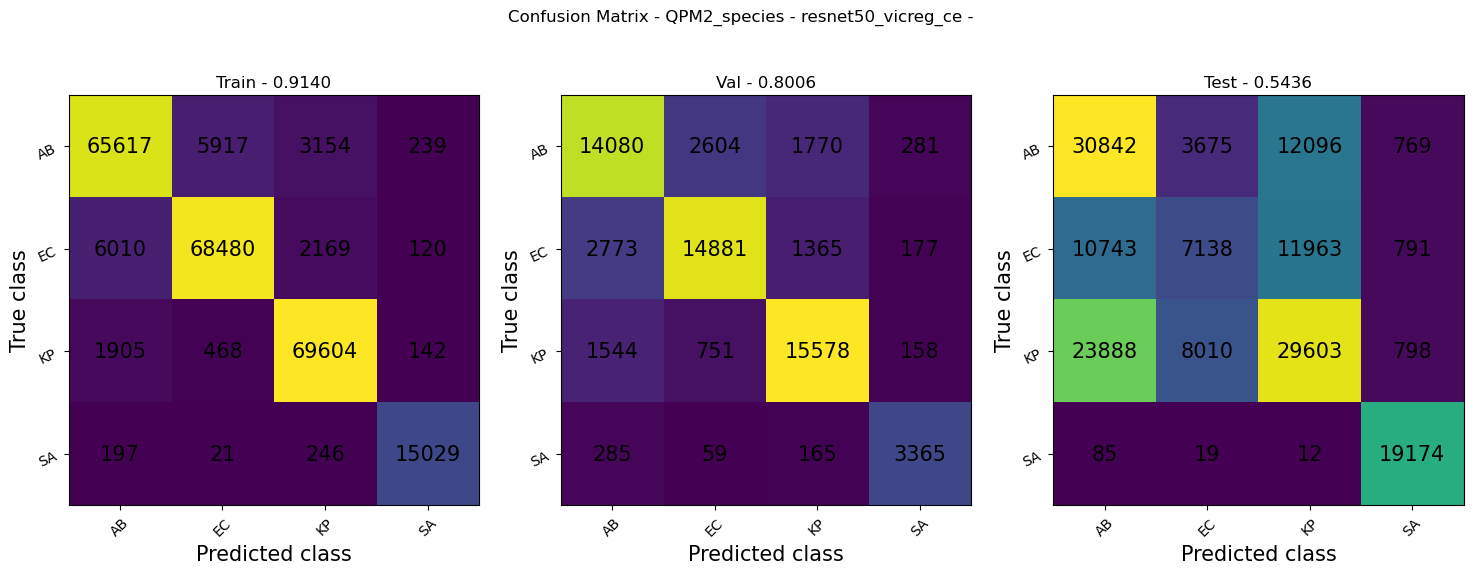

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


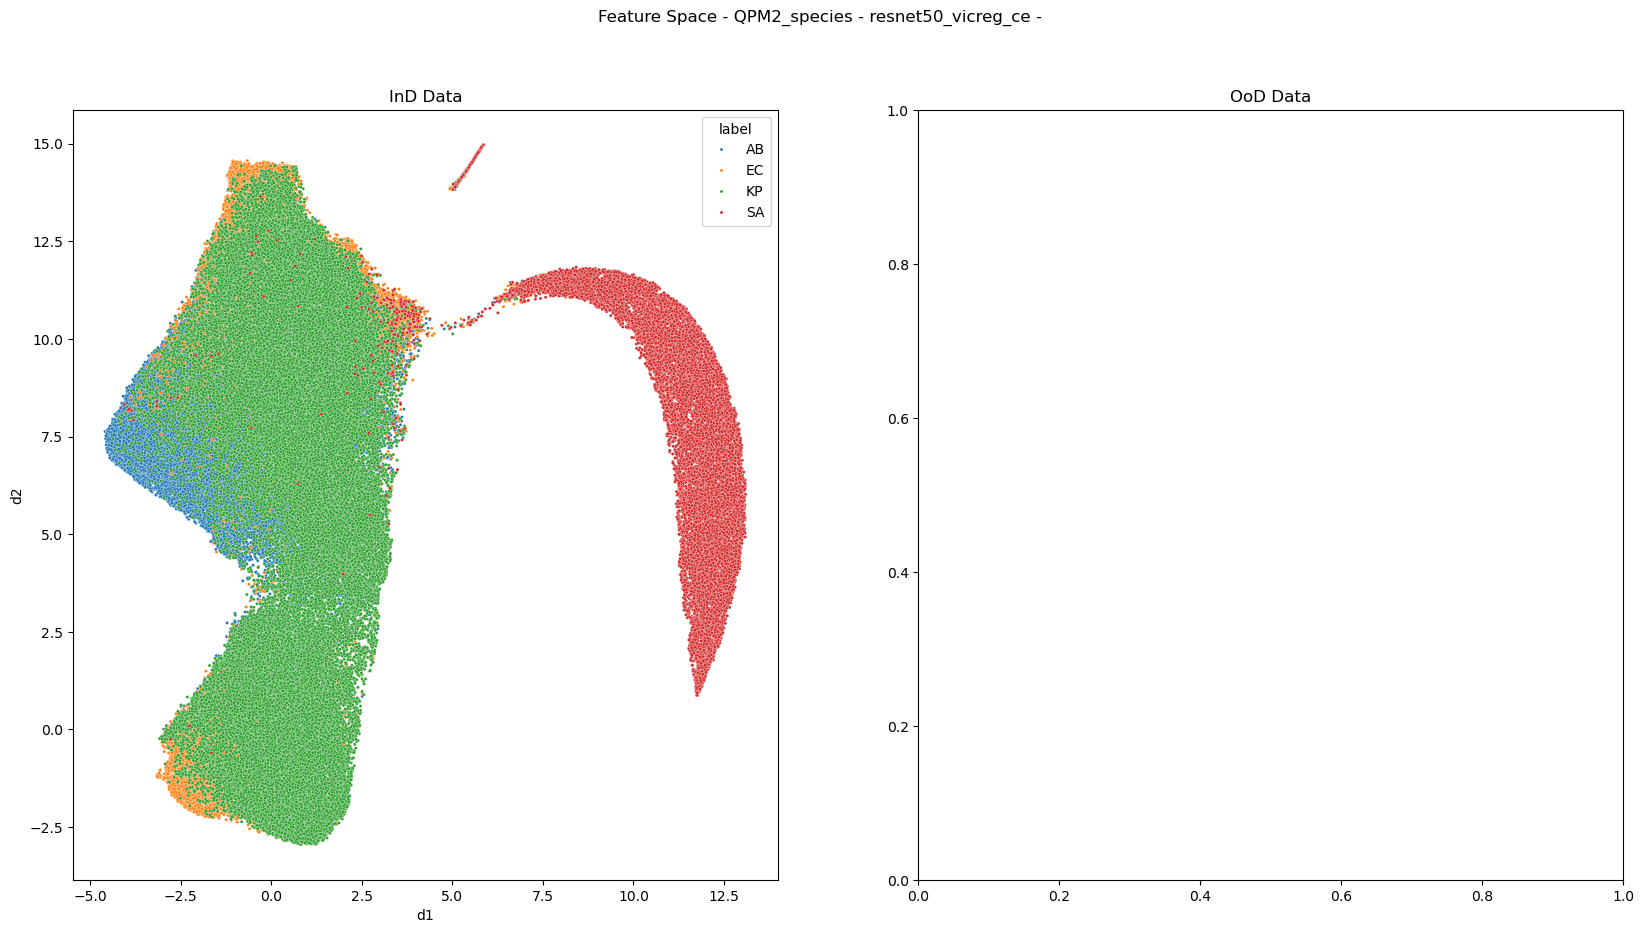

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

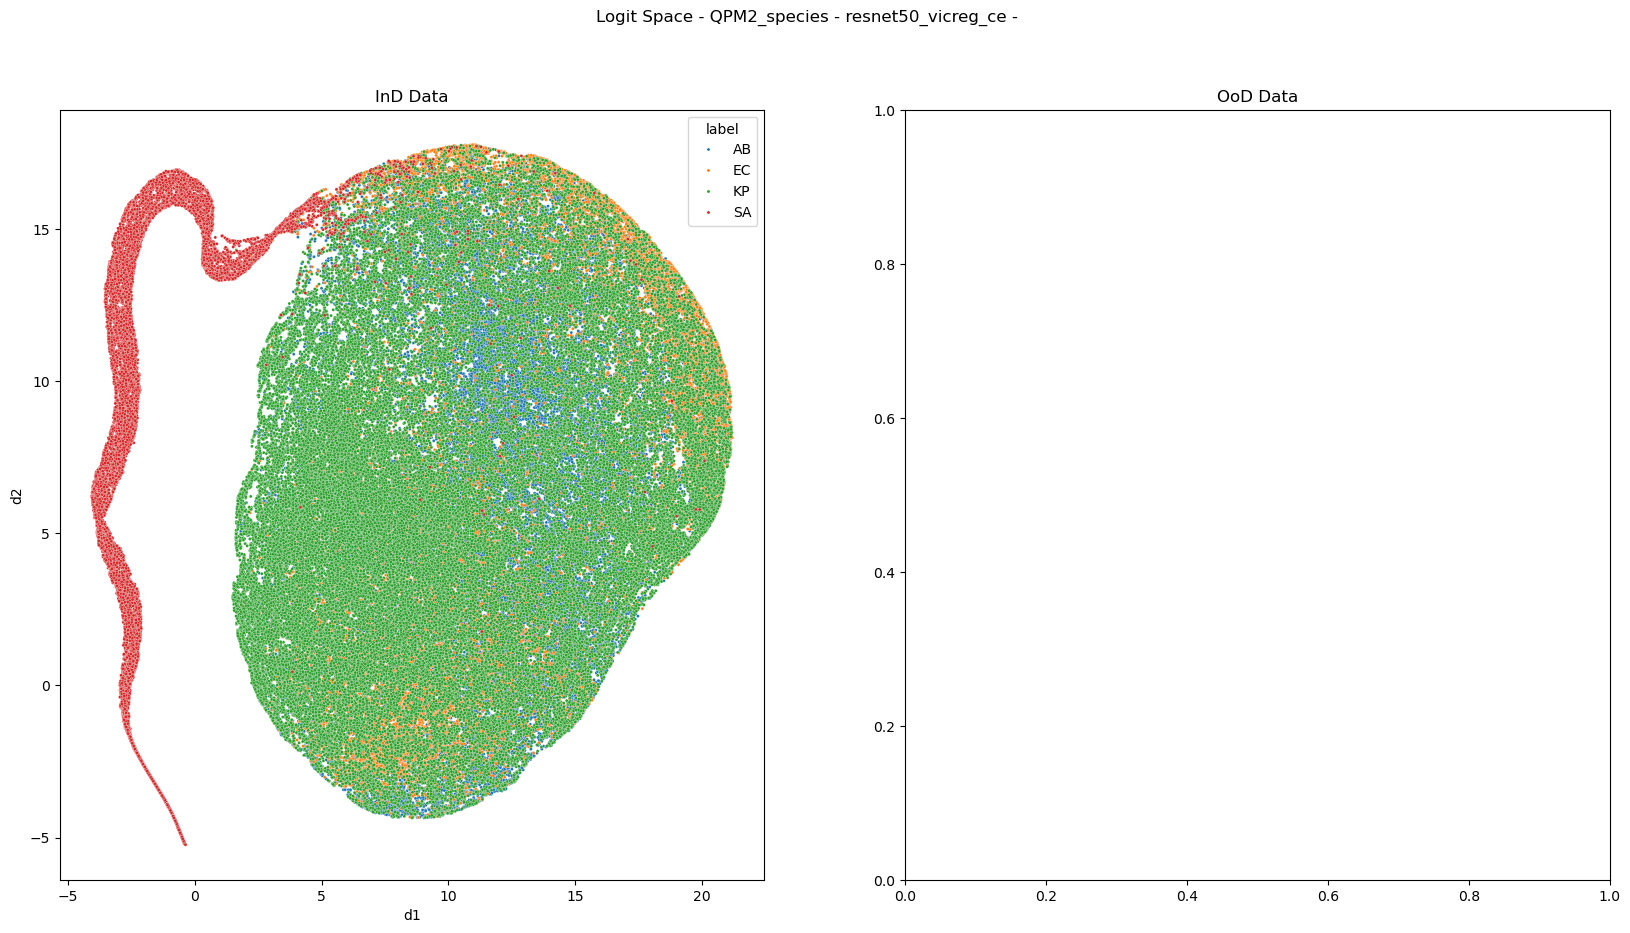

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

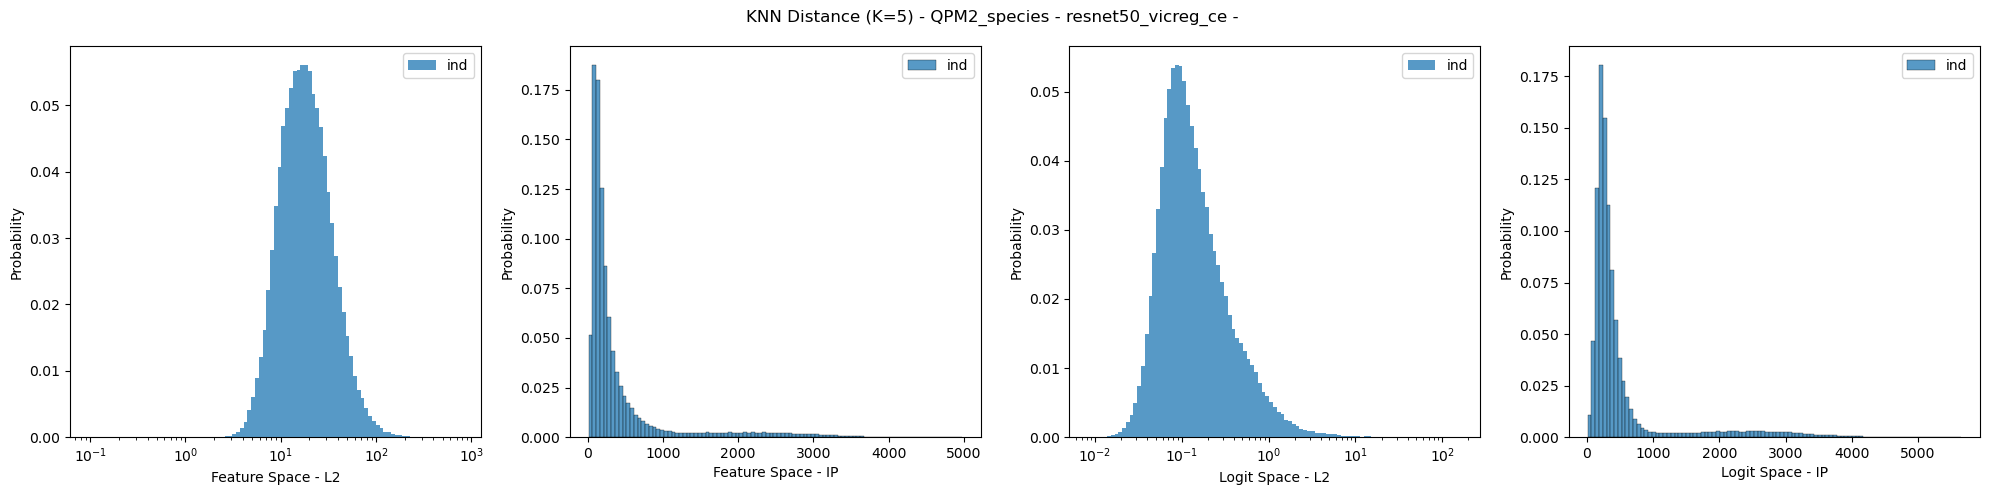

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

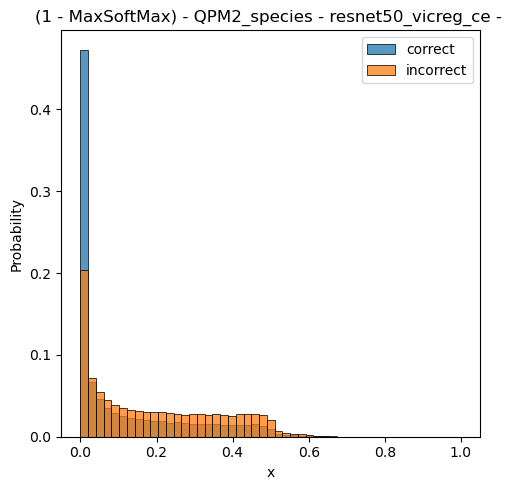

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()